## 🫁 Multimodal Survival Modeling in Pulmonary Tuberculosis
#### Chest X-ray + Clinical Covariates via Cross-Modal Attention

**Author:** Dr. Ikechukwu Ephraim Ugbo, MD
**Project:** Innovative AI Healthcare Solutions
**Framework:** TensorFlow / Keras

#### ---
#### 🔬 Study Context & SOTA References
##### This notebook implements a state-of-the-art (SOTA) multimodal architecture for predicting **time-to-major-complication** in TB patients.

##### Moving beyond simple feature concatenation, we implement **Cross-Modal Attention** to allow clinical covariates (e.g., HIV status, Age) to dynamically "attend" to specific regions of the chest X-ray. This approach is supported by recent literature:

##### **Architecture:** We utilize a transformer-based fusion strategy, which has shown superior performance in handling heterogeneous medical data compared to unimodal baselines.
##### **Modality Interaction:** Modeling the complex non-linear interactions between imaging and clinical variables (e.g., "how does diabetes status alter the risk implication of a cavitary lesion?") is critical for robust prognosis.
##### **Backbone:** We use a DenseNet121 backbone for visual feature extraction, a proven strategy for medical imaging tasks.
#
#### ---

In [1]:
# ==========================================
# Imports & Setup
# ==========================================
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


# Import custom modules

# 1. Get current directory
current_dir = os.getcwd()

# 2. Check if we are in 'notebooks' and move up if needed
if current_dir.endswith("notebooks"):
    # Move up one level to project root
    os.chdir("..")
    print(f"Changed working directory to: {os.getcwd()}")
    
    # Add root to python path so we can import src
    sys.path.append(os.getcwd())
else:
    print(f"Current working directory: {os.getcwd()}")

# Ensure your src/ folder is accessible in the python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.config import *

from src.data_utils import (
    create_matched_dataframe, 
    load_tb_cxr_dataset, 
    split_and_standardize,
    load_tb_cxr_dataset,
)
from src.model_utils import (
    TBSurvivalNet, 
    cox_ph_loss
)

from src.survival_utils import harrell_c_index
from src.callbacks import get_callbacks
from src.explainability_utils import generate_gradcam

# Set seeds for reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")

c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Changed working directory to: c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival
TensorFlow Version: 2.20.0
GPUs Available: []


#### 1. Data Preparation & Synchronization

**Challenge:** A common issue in multimodal medical AI is data heterogeneity and missing modalities.

**Strategy:**
1. We load the raw **Shenzhen TB Chest X-ray** dataset.
2. We generate synchronized synthetic clinical data (HIV,bmi etc.), (Age & Sex are taken from the shenzhen_metadata.csv) that matches the *exact* number of images, data leakage is ignored here as we do not have the patient id given here.
3. We create a "Master Key" dataframe to ensure Image $i$ always corresponds to Clinical Vector $i$.

In [2]:
# ==========================================
# Data Loading (Full Pipeline)
# ==========================================

# 1. Define Paths
IMAGE_DATA_DIR = "data/raw/images/" 
METADATA_PATH = "data/raw/shenzhen_metadata.csv" 

# 2. Master Dataset Generation (Real Metadata + Synthetic Clinical)
if not os.path.exists("data/processed/master_dataset.csv"):
    print("Generating Master Dataset...")
    df = create_matched_dataframe(IMAGE_DATA_DIR, METADATA_PATH)
else:
    print("Loading Master Dataset...")
    df = pd.read_csv("data/processed/master_dataset.csv")

# 3. Strict Splitting & Tabular Standardization
# This fits the scaler on TRAIN and applies to VAL (preventing leakage)
print("Splitting and Standardizing Clinical Data...")
train_df, val_df = split_and_standardize(df, test_size=0.2)

print(f"Training Samples:   {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")

# 4. Data Loading & Augmentation
# - Train: Resized -> Standardized -> Rotated/Brightened
# - Val:   Resized -> Standardized (No Augmentation)
train_ds = load_tb_cxr_dataset(
    train_df, 
    IMAGE_DATA_DIR, 
    batch_size=BATCH_SIZE, 
    augment=True,   # Apply Rotation/Brightness
    shuffle=True
)

val_ds = load_tb_cxr_dataset(
    val_df, 
    IMAGE_DATA_DIR, 
    batch_size=BATCH_SIZE, 
    augment=False, 
    shuffle=False
)

# 5. Pipeline Verification
(img, tab), label = next(iter(train_ds))
print(f"\nPipeline Ready:")
print(f"Image Batch: {img.shape} (Standardized)")
print(f"Tabular Batch: {tab.shape} (Standardized & Synthesized)")

Loading Master Dataset...
Splitting and Standardizing Clinical Data...
Training Samples:   529
Validation Samples: 133

Pipeline Ready:
Image Batch: (16, 224, 224, 3) (Standardized)
Tabular Batch: (16, 9) (Standardized & Synthesized)


Visualizing Training Set (Augmentation ON)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6369605].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3275619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6314809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6989815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4077182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7677165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6782401].
Clipping input data to the valid r

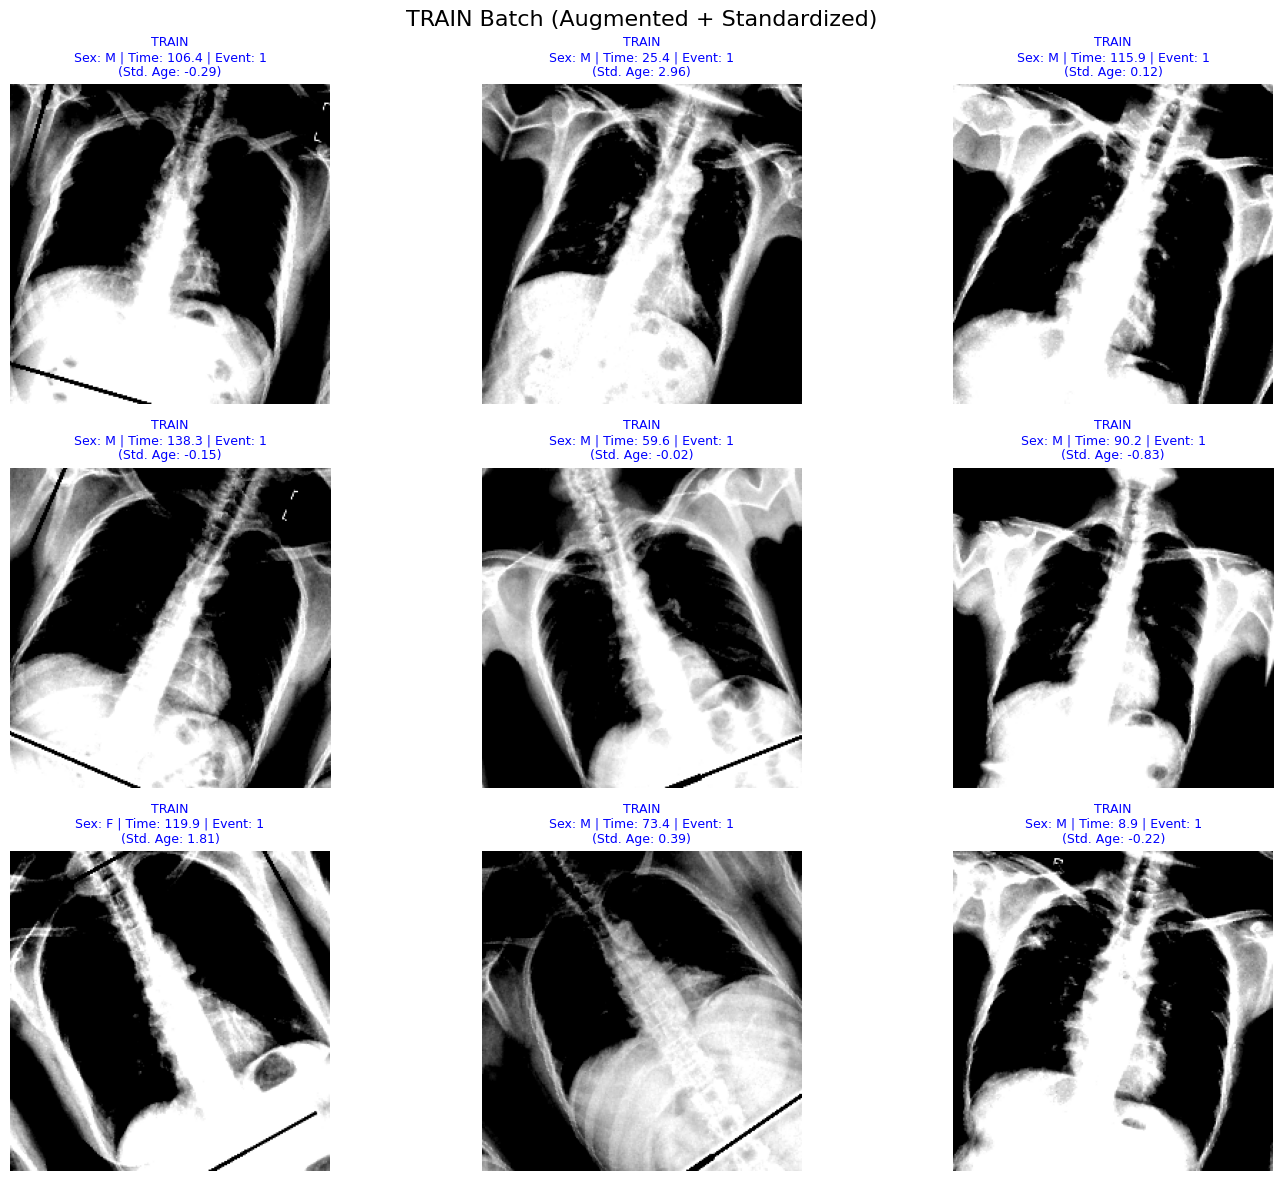


Visualizing Validation Set (No Augmentation)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4861677..1.4695685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6355414..1.2579603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6240501..1.321666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8109365..1.5340843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4062407..1.5766667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2229292..1.4331015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6889768

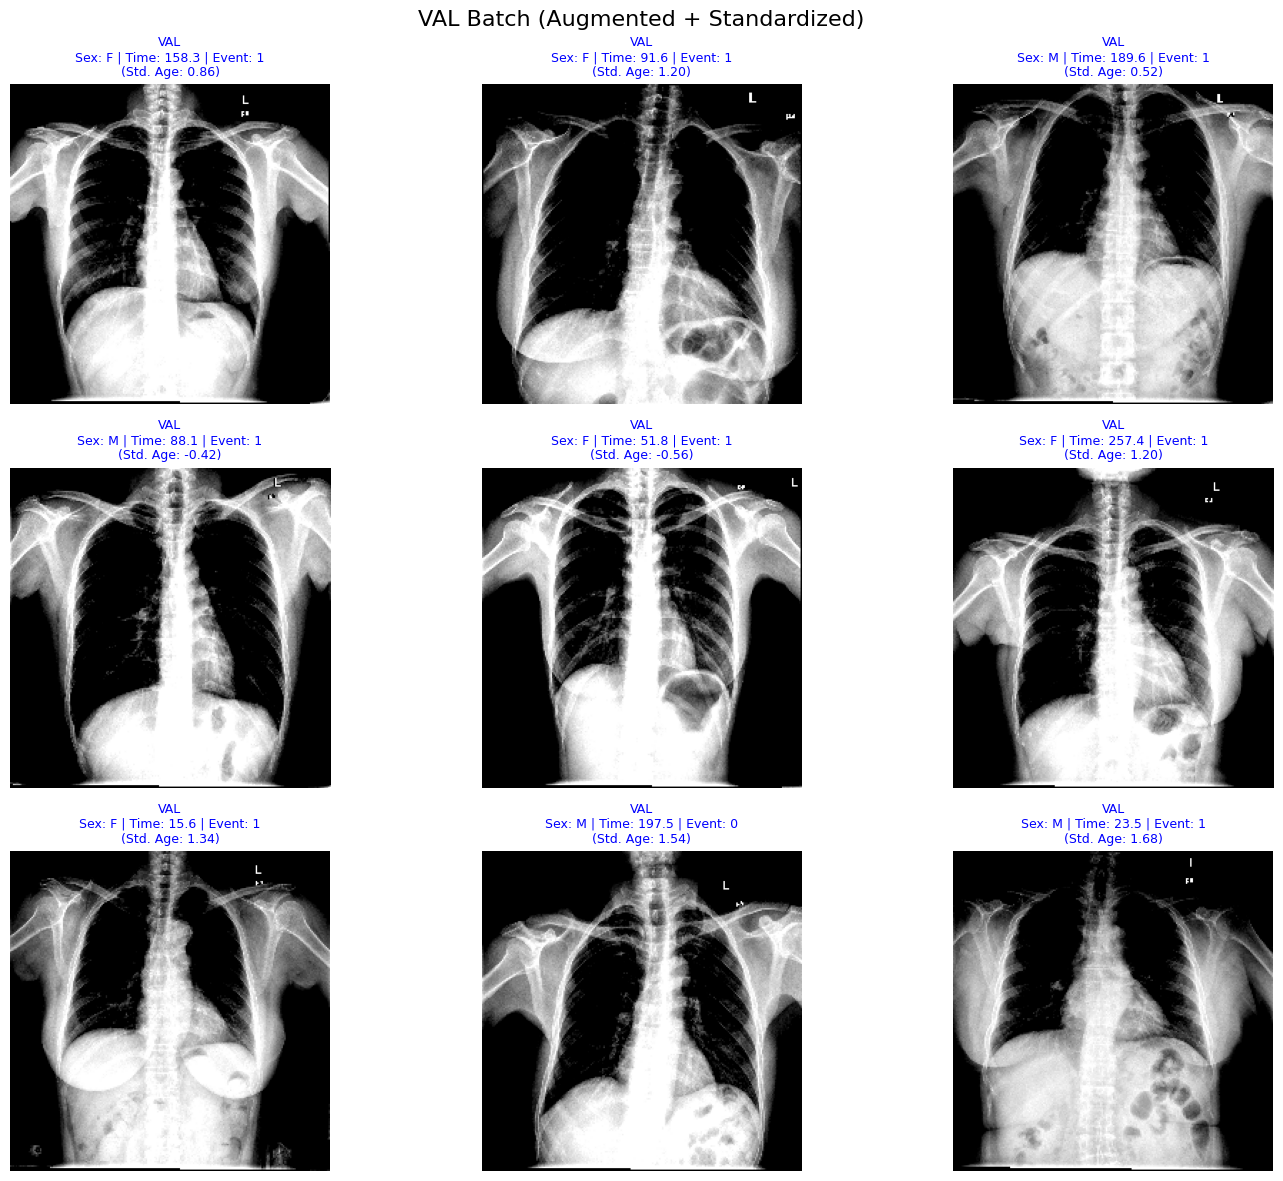

In [3]:
# ==========================================
# CELL 5: Visualizing Data Pipeline Outputs
# ==========================================

def visualize_dataset(dataset, title_prefix="Train"):
    # 1. Grab a single batch
    (images, tabular), targets = next(iter(dataset))
    
    # Convert to numpy for plotting
    images = images.numpy()
    tabular = tabular.numpy()
    targets = targets.numpy()
    
    plt.figure(figsize=(15, 12))
    
    # Show top 9 images
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i]
        
        # VISUALIZATION TRICK:
        # Standardized images have negative values (Mean=0, Std=1).
        # We clip them to the [-3, 3] range (3 standard deviations) 
        # and normalize to [0, 1] just for human eyes to see them clearly.
        # img_display = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        
        # Get metadata for Title
        # Tabular cols order: [age, bmi, hemoglobin, albumin, sex, hiv, diabetes, ...]
        # (Based on ALL_CLINICAL_COLS list order in data_utils.py)
        age = tabular[i][0] # Standardized Age
        sex = "M" if tabular[i][4] > 0.5 else "F" # Sex is index 4 (1st binary col)
        
        # Target (Survival Time)
        time = targets[i][0]
        event = int(targets[i][1])
        
        title_text = (
            f"{title_prefix}\n"
            f"Sex: {sex} | Time: {time:.1f} | Event: {event}\n"
            f"(Std. Age: {age:.2f})"
        )
        
        plt.title(title_text, fontsize=9, color='blue')
        plt.axis("off")
        
    plt.suptitle(f"{title_prefix} Batch (Augmented + Standardized)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize Training Data (Should show Rotation/Brightness changes)
print("Visualizing Training Set (Augmentation ON)...")
visualize_dataset(train_ds, title_prefix="TRAIN")

# Visualize Validation Data (Should be 'Clean' but Standardized)
print("\nVisualizing Validation Set (No Augmentation)...")
visualize_dataset(val_ds, title_prefix="VAL")

#### 2. Baseline Model: Cox Proportional Hazards

Before training the Deep Learning model, we establish a clinical baseline.
This helps us quantify the "added value" of the imaging modality.

Training Baseline Cox Model on 529 clinical records...

📊 BASELINE RESULTS (Clinical Only)
Train C-Index:      0.6376
Validation C-Index: 0.6127  <-- BEAT THIS SCORE

Top 5 Risk Factors (Hazard Ratios):
            exp(coef)             p
covariate                          
hiv          2.608296  2.307466e-15
age          1.204024  5.129987e-05
albumin      1.101211  2.468643e-02
sex          1.061226  5.320066e-01
hemoglobin   1.027026  5.492619e-01


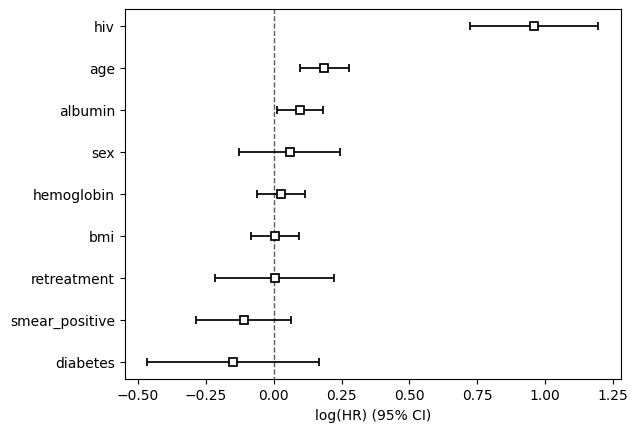

In [4]:
# ==========================================
# Baseline Cox Proportional Hazards Model
# ==========================================
from lifelines import CoxPHFitter

# 1. Define Features
# We use the exact same columns defined in src/data_utils.py
clinical_features = ALL_CLINICAL_COLS

# 2. Prepare Subsets
# We filter the dataframes to keep only the features + targets
# (train_df and val_df are already standardized from Cell 4)
cph_train = train_df[clinical_features + ["time", "event"]].copy()
cph_val   = val_df[clinical_features + ["time", "event"]].copy()

print(f"Training Baseline Cox Model on {len(cph_train)} clinical records...")

# 3. Fit the Model (On Training Data ONLY)
# penalizer=0.1 helps prevent errors if some synthetic features are perfectly correlated
cph = CoxPHFitter(penalizer=0.1) 

try:
    cph.fit(cph_train, duration_col="time", event_col="event")
    
    # 4. Evaluate (The Metric to Beat)
    c_index_train = cph.score(cph_train, scoring_method="concordance_index")
    c_index_val   = cph.score(cph_val, scoring_method="concordance_index")

    print("\n" + "="*40)
    print(f"📊 BASELINE RESULTS (Clinical Only)")
    print("="*40)
    print(f"Train C-Index:      {c_index_train:.4f}")
    print(f"Validation C-Index: {c_index_val:.4f}  <-- BEAT THIS SCORE")
    print("="*40)
    
    # 5. Interpretability (Hazard Ratios)
    # exp(coef) > 1.0 means HIGHER Risk (Bad)
    # exp(coef) < 1.0 means LOWER Risk (Good)
    print("\nTop 5 Risk Factors (Hazard Ratios):")
    summary = cph.summary[['exp(coef)', 'p']]
    print(summary.sort_values('exp(coef)', ascending=False).head(5))

    # Optional: Plot the effects
    cph.plot() 

except Exception as e:
    print(f"❌ Cox Model Convergence Error: {e}")
    print("Try increasing the 'penalizer' parameter slightly.")

In [5]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 529 total observations, 66 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 529
number of events observed = 463
   partial log-likelihood = -2434.62
         time fit was run = 2025-12-29 07:54:08 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
age             0.19      1.20      0.05            0.10            0.28                1.10                1.32
bmi             0.01      1.01      0.05           -0.08            0.09                0.92                1.10
hemoglobin      0.03      1.03      0.04           -0.06            0.11                0.94                1.12
albumin         0.10      1.10      0.04            0.01            0.18                1.01                1.20
sex             0.06      1.06      0.10           -0.13            0.25                0.88                1.28
hiv             0.96      2.61      0.12            0.72            1.20                2.06                3.31
diabetes       -0.15      0.86      0.16           -0.47            0.17                0.63                1.18
smear_positive -0.11      0.90      0.09           -0.29            0.06                0.75                1.07
retreatment     0.00      1.00      0.11           -0.22            0.22                0.81                1.25

                cmp to     z      p  -log2(p)
covariate                                    
age               0.00  4.05 <0.005     14.25
bmi               0.00  0.12   0.91      0.14
hemoglobin        0.00  0.60   0.55      0.86
albumin           0.00  2.25   0.02      5.34
sex               0.00  0.62   0.53      0.91
hiv               0.00  7.92 <0.005     48.62
diabetes          0.00 -0.93   0.35      1.50
smear_positive    0.00 -1.24   0.22      2.21
retreatment       0.00  0.03   0.98      0.03
---
Concordance = 0.64
Partial AIC = 4887.25
log-likelihood ratio test = 76.25 on 9 df
-log2(p) of ll-ratio test = 40.02

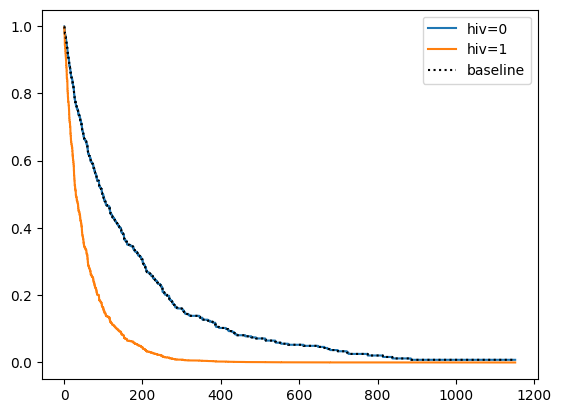

In [6]:
cph.plot_covariate_groups('hiv', values=[0, 1]);

#### 3. Multimodal Architecture

We implement the **Cross-Modal Attention Network** (TBSurvivalNet).

#### How it works:
1. **Image Encoder:** `DenseNet121` (without pooling) extracts a $7 \times 7$ grid of visual features.
2. **Tabular Encoder:** Clinical features are projected into a high-dimensional embedding space.
3. **Cross-Attention:** The clinical embedding acts as a "Query" to attend to the spatial visual "Keys/Values". This allows the model to focus on specific lung regions relevant to the patient's specific comorbidities.

In [7]:
# ==========================================
# Initialize TBSurvivalNet
# ==========================================

# 1. Get feature count
num_features = train_df[train_df.columns.intersection(
    ["age", "bmi", "hemoglobin", "albumin", "sex", "hiv", "diabetes", "smear_positive", "retreatment"]
)].shape[1]

# 2. Build Model
model = TBSurvivalNet(
    input_shape_img=(224, 224, 3),
    num_clinical_features=num_features,
)

model.summary()

Model: "TBSurvivalNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,583,681 (28.93 MB)

 Trainable params: 545,665 (2.08 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [8]:
# ==========================================
# CELL 8: Compile
# ==========================================
# Compile with Adam optimizer and Cox PH loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=cox_ph_loss
)
print("TBSurvivalNet compiled successfully!")

TBSurvivalNet compiled successfully!


In [9]:
# # ==========================================
# # Placeholder Training Loop
# # ==========================================

# # 1. Print to verify
# print(f"🚀 Starting training for: {MODEL_NAME}")

# # 2. Get callbacks using the dynamic paths
# my_callbacks = get_callbacks(
#     model_name=MODEL_NAME,
#     save_dir="outputs/models",
#     log_dir="outputs/tensorboard"
# )

# # 3. Training Loop
# history = model.fit(
#    x=train_ds,
#    validation_data=val_ds,
#    epochs=EPOCHS, # Reduced for demo
#    callbacks = my_callbacks
# )

In [10]:
# Load the weights into that model
model.load_weights("outputs/models/tbsurvivalnet_v1.weights.h5")

print("Weights loaded successfully.")

Weights loaded successfully.


In [11]:
# 1. Prepare Ground Truth (Time and Event)
# We convert to numpy arrays to ensure your loop indexing [i] works perfectly
y_val_times = val_df['time'].values
y_val_events = val_df['event'].values

# 2. Get Predictions (Risk Scores)

# --- Cox Proportional Hazards (CPH) ---
# predict_partial_hazard gives the risk score relative to the baseline
cph_preds = cph.predict_partial_hazard(val_df)
cph_scores = cph_preds.values  # Convert pandas Series to numpy array

# --- TBSurvivalNet (Deep Learning) ---
# We pass the list of inputs [Images, Tabular]
# .flatten() ensures we get a 1D array like [0.4, 0.8, ...] instead of [[0.4], [0.8]]
dl_raw_preds = model.predict(val_ds, verbose=0)
dl_scores = dl_raw_preds.flatten()

print("Predictions generated. calculating C-Index (this might take a moment)...")

# 3. Calculate C-Index using YOUR function
c_index_cph = harrell_c_index(y_val_times, cph_scores, y_val_events)
c_index_dl = harrell_c_index(y_val_times, dl_scores, y_val_events)

# 4. Display Results
print("\n" + "="*40)
print("       MODEL PERFORMANCE RESULTS       ")
print("="*40)
print(f"Baseline CoxPH C-Index:   {c_index_cph:.4f}")
print(f"TBSurvivalNet C-Index:    {c_index_dl:.4f}")
print("-" * 40)

if c_index_dl > c_index_cph:
    diff = c_index_dl - c_index_cph
    print(f"✅ TBSurvivalNet improved by: +{diff:.4f}")
else:
    diff = c_index_cph - c_index_dl
    print(f"⚠️ CoxPH is currently better by: +{diff:.4f}")
print("="*40)

Predictions generated. calculating C-Index (this might take a moment)...

       MODEL PERFORMANCE RESULTS       
Baseline CoxPH C-Index:   0.6127
TBSurvivalNet C-Index:    0.5590
----------------------------------------
⚠️ CoxPH is currently better by: +0.0537


#### 4. Training & Explainability

Post-training, we will use **Grad-CAM** to visualize which lung regions the model focused on.

> "Clinicians require transparent, actionable models for adoption in decision-making."

In [ ]:
# Extract one batch from the validation dataset
# val_ds yields: ((images, tabular), labels)
for (img_batch, tab_batch), label_batch in val_ds.take(1):
    # Select the fourth patient in the first batch
    patient_img = img_batch[3]
    patient_tab = tab_batch[3]    
    # Break immediately so we don't loop through the whole dataset
    break

print(f"Selected Patient Image Shape: {patient_img.shape}")
print(f"Selected Patient Tabular Data: {patient_tab.numpy()}")

Selected Patient Image Shape: (224, 224, 3)
Selected Patient Tabular Data: [-0.4245517  -0.28341734  0.69925606 -1.1112449   1.          0.
  0.          1.          0.        ]


Generating Grad-CAM heatmap...


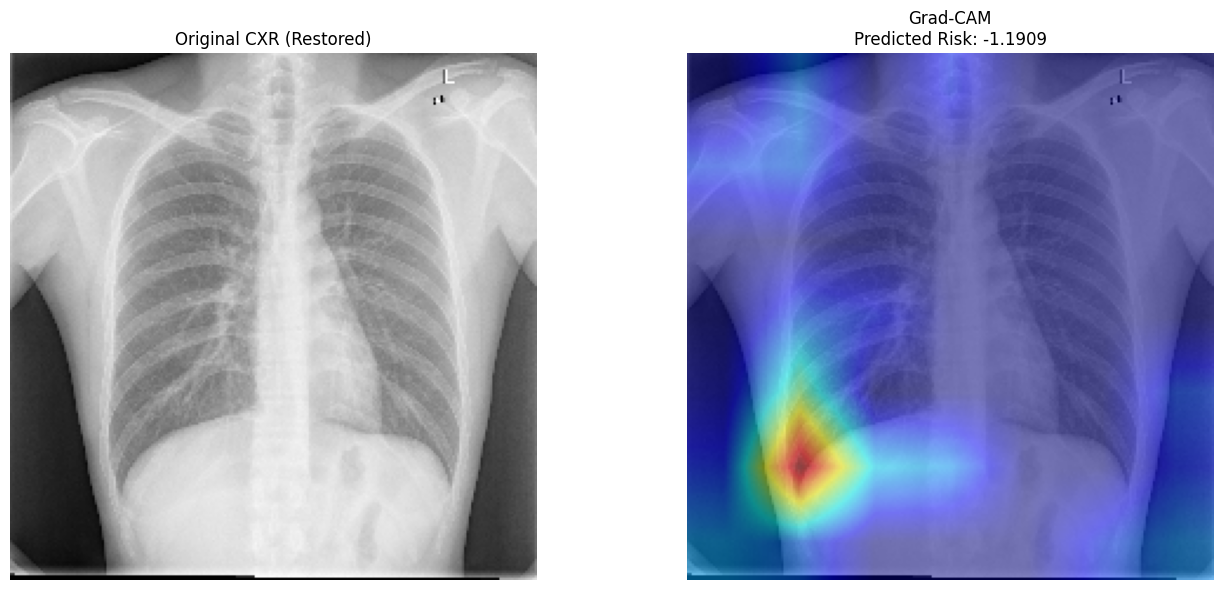

In [23]:
print("Generating Grad-CAM heatmap...")

# Run the visualization
generate_gradcam(
    model=model,
    image=patient_img,
    tabular_sample=patient_tab,
    layer_name="conv5_block16_concat",
    alpha=0.5
)

## Interpretation and Next Steps

- Compare clinical vs multimodal performance
- Perform subgroup analyses (HIV, age)
- External validation
- Competing risks modeling
- Manuscript preparation


### Summary

This notebook provides a reproducible, interpretable framework
for survival modeling in pulmonary tuberculosis using
chest X-ray imaging and clinical data.

It serves as the foundation for further validation and publication
within the **Innovative AI Healthcare Solutions** initiative.
